# Log
This page records ideas and notes chronologically. An attempt will be made to avoid making any edits other than fixing formatting or typos.


## 2022-09-27
Decided to start writing down notes. 

At this point, I have a model that is reasonably good at predicting spikes for a single cell, given the stimulus and the spike history. This is using the spike distance learning objective. 

I'll spend a bit of time today seeing how small I can make the model performance degrades. Mainly I'll try reducing channel and layer counts. I don't want to be needlessly carrying around a heavy model into the next few experiments.


I tried out the experimentation automation tool, Guild AI; however, it was very finicky and configuration file heavy. It was especially hard to get relative paths working. In the end, I figured a manual approach would be more satisfying.

## 2022-09-29
From experiment 1.1.1-1.1.3, the distance field output seems to becoming more capable of pinpointing spikes with increased channel count and number of layers. The 50ms correlation calculation from the evaluation notebook increases 1.1.1 < 1.1.2 < 1.1.3. This is despite both the best-loss for the validation set showing the opposite (1.1.3 < 1.1.2 < 1.1.1). Notably too is the discrepancy between the notebook calculated correlation and the Trainable one. The notebook calculation is often tweaked. Would be good to take more effort to keep them in sync. Another possible explanation could be the presence of a weight regularization term being included in the loss. I'm using the weight regularization term of the PyTorch optimizer; however, I was under the impression that any effects of this would not appear in the loss term. A little test shows that this is in fact the behaviour (no weight regularization term in the loss):

In [1]:
import torch
import torch.nn.functional as F

def weightdecay_test():
    a = torch.Tensor([[
        [-1,0,1,2,3]
    ]])
    W = torch.Tensor([
        [1,1,1,1,1]]
    )
    
    def net(x):
        y = F.linear(x, W)
        return y
        
    target = torch.Tensor([[[0]]])
    def loss_without_reg():
        loss_fn = torch.nn.L1Loss(reduction='sum')
        optimizer_0 = torch.optim.Adam(params=[W], lr=0.01, weight_decay=0)
        optimizer_0.zero_grad()
        b = net(a)
        loss = loss_fn(b, target=target)
        return loss
    
    def loss_with_reg():
        loss_fn = torch.nn.L1Loss(reduction='sum')
        optimizer_0 = torch.optim.Adam(params=[W], lr=0.01, weight_decay=10)
        optimizer_0.zero_grad()
        b = net(a)
        loss = loss_fn(b, target=target)
        return loss
   
    print(f'Without: {loss_without_reg()}')
    print(f'With: {loss_with_reg()}')
    
weightdecay_test()

Without: 5.0
With: 5.0


So what else could be causing the bigger models to have higher validation loss, yet have a better looking distance field output? Maybe the answer is that "better looking" is my subjective guess, and a guess based on a very small portion of the data. But the subjective guess shouldn't be ignored, as it is proximate to easier by-eye spike inference, and the current inference scripts are heavily inspired by by-eye approaches like looking for local minima and not trying to calculate the maximum likelihood solution via energy minimization. It's possible that the smaller models have a better distance field output, but the smoothness makes inference harder when using hacky inference scripts, which the current inference scripts definitely are. 

## 2022-11-04
I added labels for the "cluster id", the label given by the spike sorter to what it thinks are individual cells. I made these unique for different recordings, but not in a way that allowed the recording to be an input feature. I tried a few ways of feeding this information into the network with the aim of both getting a single-model that can predict for any of the clusters. The main ways tried were:

  1. embedding -> VAE -> FC layers -> concatenate as new CNN layer & bias
  2. embedding -> VAE -> FC layers -> weights of single residual layer (a hypernetwork)
  3. embedding -> VAE -> many parallel FC layers & attention into kernel weight stores-> weights of many residual layers (big hypernetwork)
  4. embedding -> VAE -> concat to input, and swap out remaining CNN for transformer.
  
The predictive performance increased from 1->4. Training time was punishingly slow for 3. I expect a much more efficient implementation is possible for 3, and I still think it has potential. 4 is what I'll use going forward. The transformer improves the predictive performance quite a bit, so I'll just use this as the default approach going forward. The head of the transformer is a fully-connected layer to predict the spike distances. 

### Clustering
The network does a decent job of clustering the cells. This was investigated by comparing the spike-triggered-average kernels for the cells in the latent space. A 2D latent space was found to be ineffective. Notably, points were getting stuck by being surrounded by other points. In the end, I settled on around 20-40 dimensions, and used t-SNE to visualize the points in 2D. It is in these 2D representations that I used hover-over tooltips to compare the spike-triggered-average kernels. The t-SNE parameters had a significant effect on the organization of the 2D representation.

I observed a significant grouping of cells from the same recording. The fact that cells were in the same recording was not given as an input suggests that individual recordings had different characteristics relevant for spike prediction. Some supporting evidence for this idea is that I noted the recording that seemed to have the strongest clustering effect and asked the experimenter if there was anything of note regarding this experiment. His response was this was a particularly poor recording.

It order to obtain a VAE clustering of cells that more strongly relies on the behaviour of the cells, I made another network that was not given spike history as an input. By doing this, the network cannot learn about the behaviour of the cell based on the spike history. This unsurprisingly negatively effected predictive performance, but it produced a latent space that had much more obvious groups whose spike-triggered-average kernels were in good agreement, more so that before. Furthermore, there were less groupings formed by cells from the same recording. 

### 2022-11-15
Had some success the spike inference. I tried a gradient descent based approach, where a set number of spikes, typically more than would be expected, and had their position move in order to reduce the error. Error in this scenario is the L2 error between the model's distance output and the distance array that would result from a candidate spike sequence. The gradient based approach seemed to never escape the local minimum near the initialization state. I tabled this approach temporarily while investigating alternatives.

Another approach tried was an expectation-minimization (EM) inspired approach. Using the EM algorithm parlance, I initialized $K$ binary latent variables, where $K$ equals the number of timesteps over which we are inferring the spike sequence. The $K$ binary variables can be 1 representing a spike or 0 representing no spike. All $K$s are initialized to 1 representing the unlikely scenario that on every timestep there is a spike. Each $K$ has a *responsibility* to explain a slice of the interval. In standard EM, a single point (in this case timesteps) can have responsibility assigned to multiple latent variables $K$; however, in this case, I make the simplification that a timestep is assigned to only a single latent variable. The loop of the algorithm repeatedly decides whether or not to "turn off" (set to zero) any of the $K$ latents. If a single latent is turned-off, then the responsibilities get reassigned. Unlike normal EM, I don't let a latent change back to 1 once it becomes 0. This is just an optimization to make the algorithm run in reasonable time. If we are careful about our initialization (starting with all latents set to 1) and the order in which we consider the latent variables (start with the one with the largest benefit of removal), then the algorithm seems to be very reliable at converging to a solution that looks good to the eye.   

Below is an example result, in the linear distance space. It looks like it is too trigger happy with the spikes; however, on zooming it, it turns out to be quite accurate, as each elbow of the target contains 2-3 spikes each in this case.
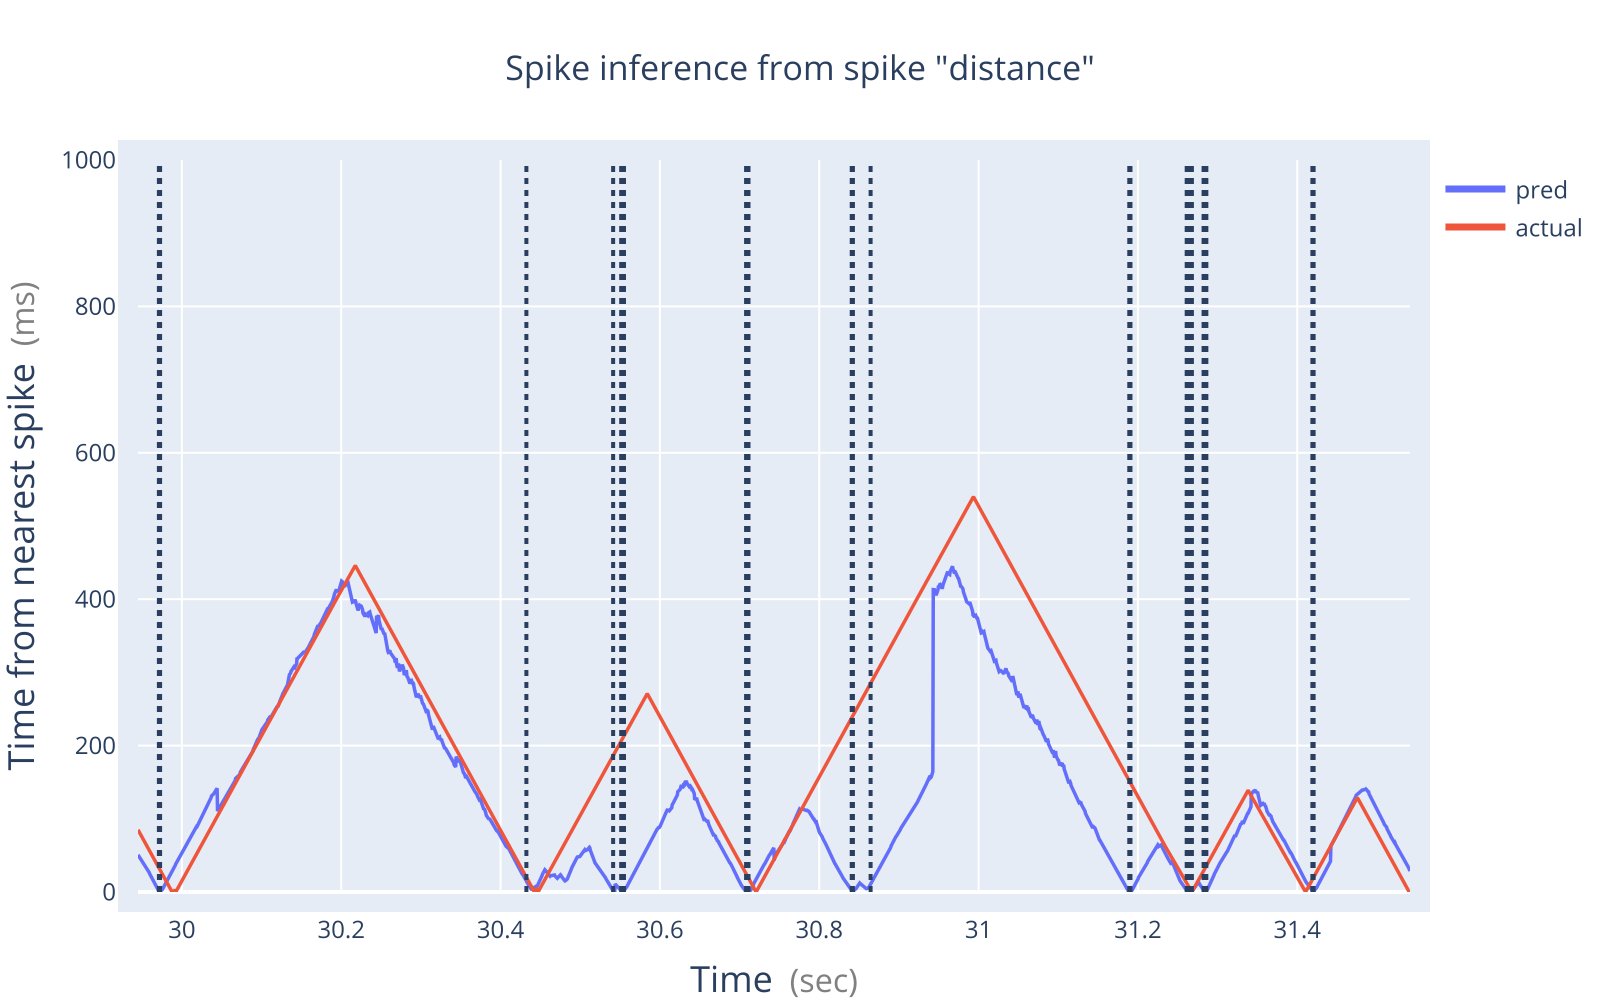

When using the in

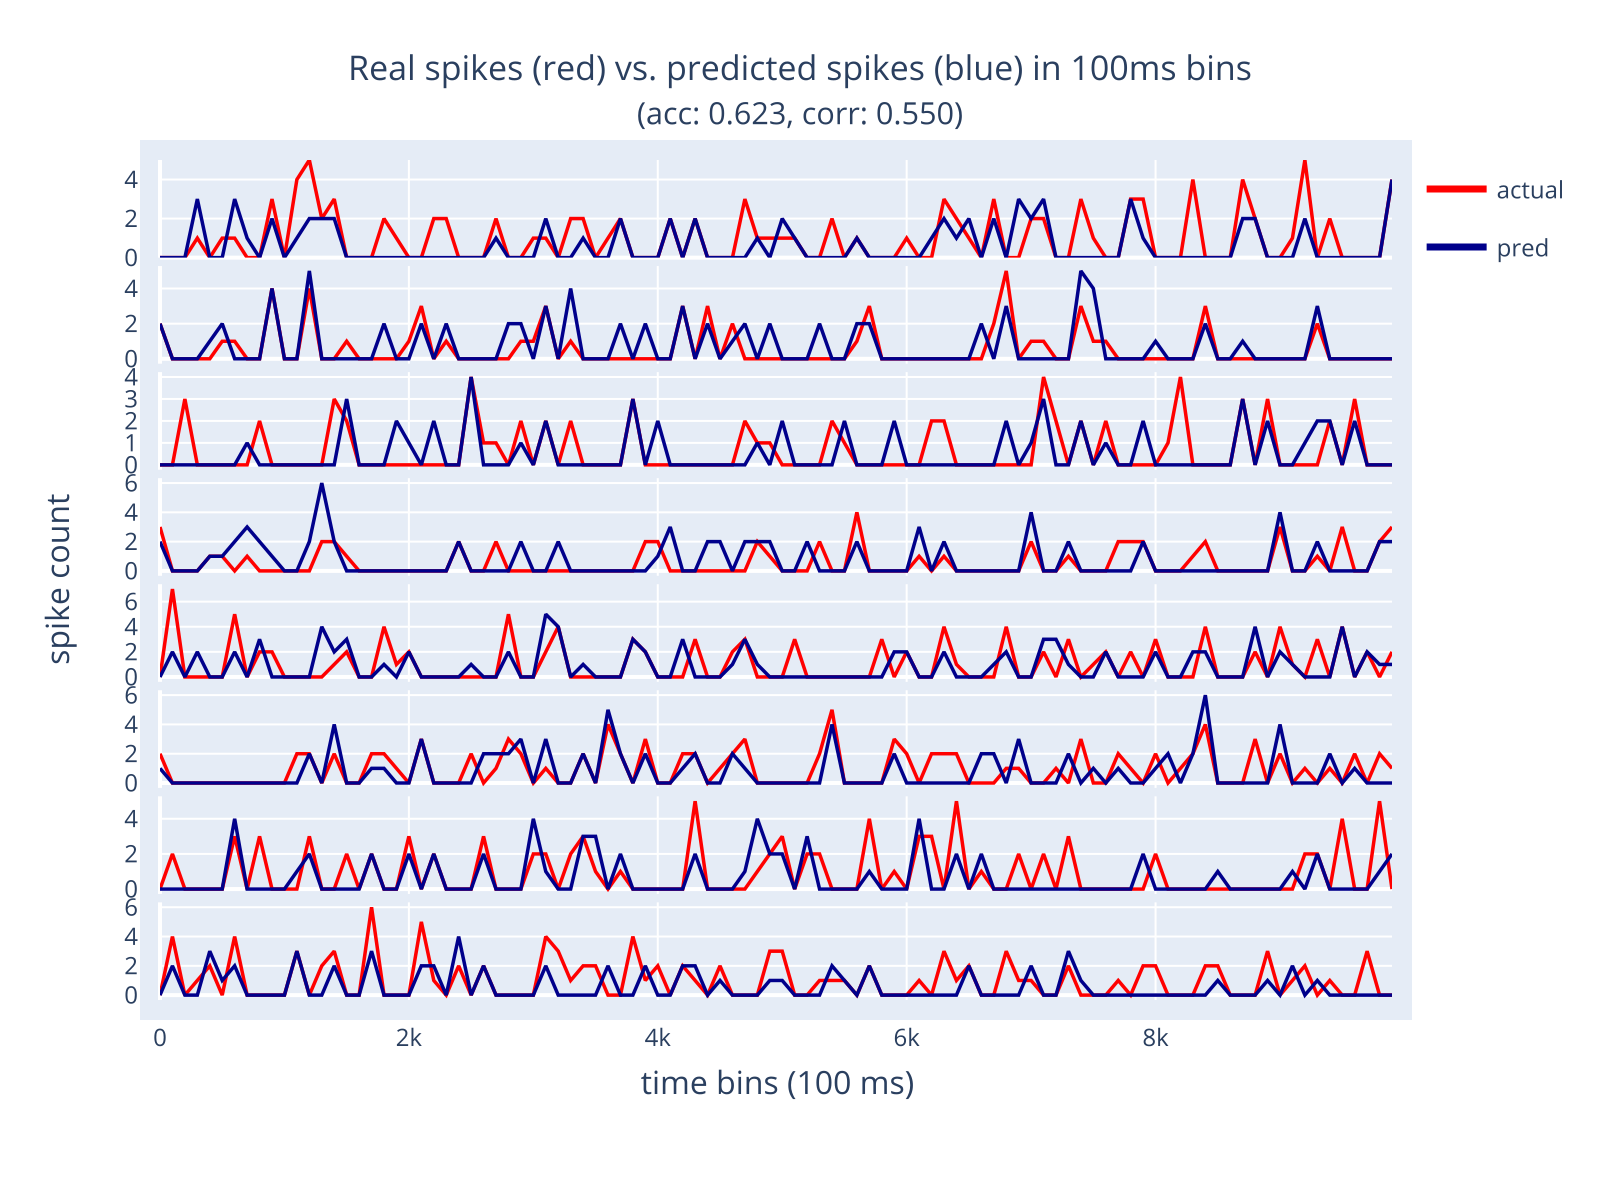